In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import seaborn as sns

from os.path import join

from fixation_extraction import IVT
from eyetracking.visualization.static_visualization import scanpath_visualization
from aoi_extraction import ThresholdBased, GradientBased, OverlapCLustering, AOIExtractor

from _utils import _get_MEC

DATA_PATH = join('..', 'test_data')

In [2]:
def remove_points(df, x_min, x_max, y_min, y_max):
    df = df[df['norm_pos_x'] <= x_max]
    df = df[df['norm_pos_x'] >= x_min]
    df = df[df['norm_pos_y'] >= y_min]
    df = df[df['norm_pos_y'] <= y_max]
    return df

data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_gaze_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_gaze_2.xlsx'))], axis=0)

data.drop(['world_index', 'confidence', 'base_data'], axis=1, inplace=True)
data = remove_points(data, -1, 1, -1, 1)
data['gaze_timestamp'] = data['gaze_timestamp']

In [3]:
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'

ivt = IVT(x=x, y=y, t=t, pk=['Participant', 'tekst'], threshold=0.5, )
ivt_data = ivt.transform(data)
ivt_data.head()

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,diameters,centers,duration
0,1,1,0.239834,0.516343,317242.708403,317242.721633,0.000195,0.002556,0.002556,"[0.24017877960158973, 0.5163239244528413]",0.013230
1,1,1,0.245384,0.505449,317242.735084,317242.835534,0.000179,0.002909,0.006973,"[0.24534965207218118, 0.5053153068756444]",0.100450
2,1,1,0.242721,0.509288,317242.847781,317242.847781,0.000712,0.000712,0.000000,"[0.2427212672736854, 0.5092879141035382]",0.000000
3,1,1,0.236628,0.517890,317242.861760,317242.877572,0.001193,0.001974,0.003286,"[0.23694195737802515, 0.517857872489202]",0.015812
4,1,1,0.236702,0.511007,317242.891984,317242.891984,0.002011,0.002011,0.000000,"[0.2367022278961963, 0.5110065167407356]",0.000000


In [4]:
overlap = OverlapCLustering(x, y, "diameters", "centers", ['Participant', 'tekst'], "AOI", eps=0.01)
overlap.fit(ivt_data)
overlap_data = overlap.transform(ivt_data)
overlap_data.head()

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,diameters,centers,duration,AOI
0,1,1,0.239834,0.516343,317242.708403,317242.721633,0.000195,0.002556,0.002556,"[0.24017877960158973, 0.5163239244528413]",0.013230,43
1,1,1,0.245384,0.505449,317242.735084,317242.835534,0.000179,0.002909,0.006973,"[0.24534965207218118, 0.5053153068756444]",0.100450,43
2,1,1,0.242721,0.509288,317242.847781,317242.847781,0.000712,0.000712,0.000000,"[0.2427212672736854, 0.5092879141035382]",0.000000,43
3,1,1,0.236628,0.517890,317242.861760,317242.877572,0.001193,0.001974,0.003286,"[0.23694195737802515, 0.517857872489202]",0.015812,43
4,1,1,0.236702,0.511007,317242.891984,317242.891984,0.002011,0.002011,0.000000,"[0.2367022278961963, 0.5110065167407356]",0.000000,43


In [5]:
overlap_data["AOI"].isnull().sum(), overlap_data.shape[0]

(0, 27420)

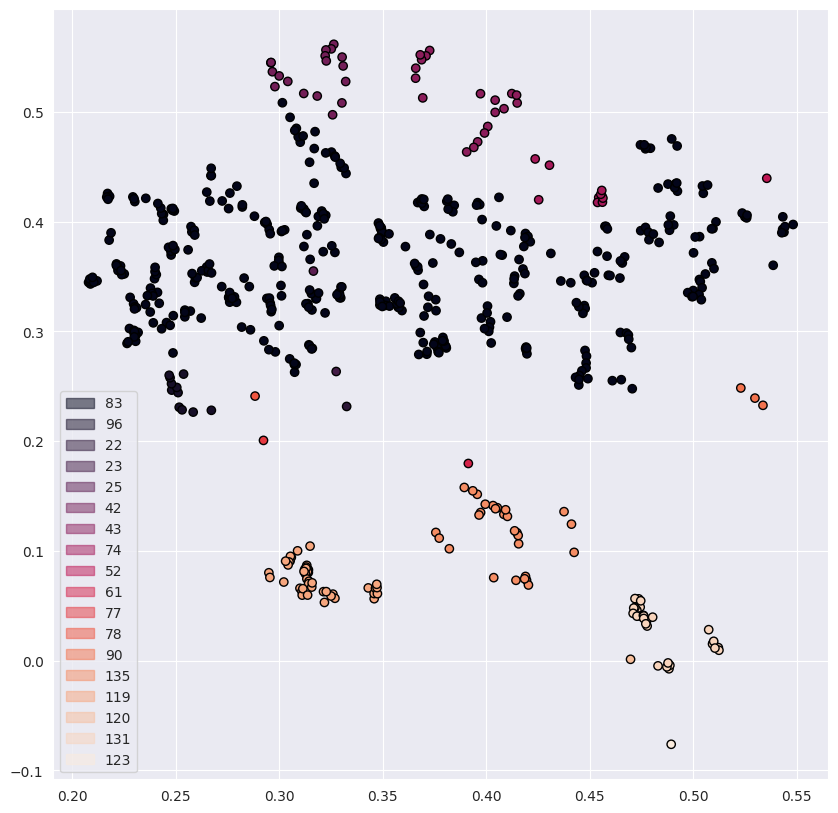

In [6]:
scanpath_visualization(overlap_data[(overlap_data['Participant'] == 1) & (overlap_data['tekst'] == 2)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [7]:
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'

methods = [ThresholdBased(threshold=0, window_size=3), GradientBased(threshold=0.1, window_size=6)]

pipeline = Pipeline([('IVT', IVT(x=x, y=y, t=t, pk=['Participant', 'tekst'], threshold=0.10)), ('AOIDefining', AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], aoi_name='AOI', show_best=True))])
pipeline.fit(data)
prep_data = pipeline.transform(data)

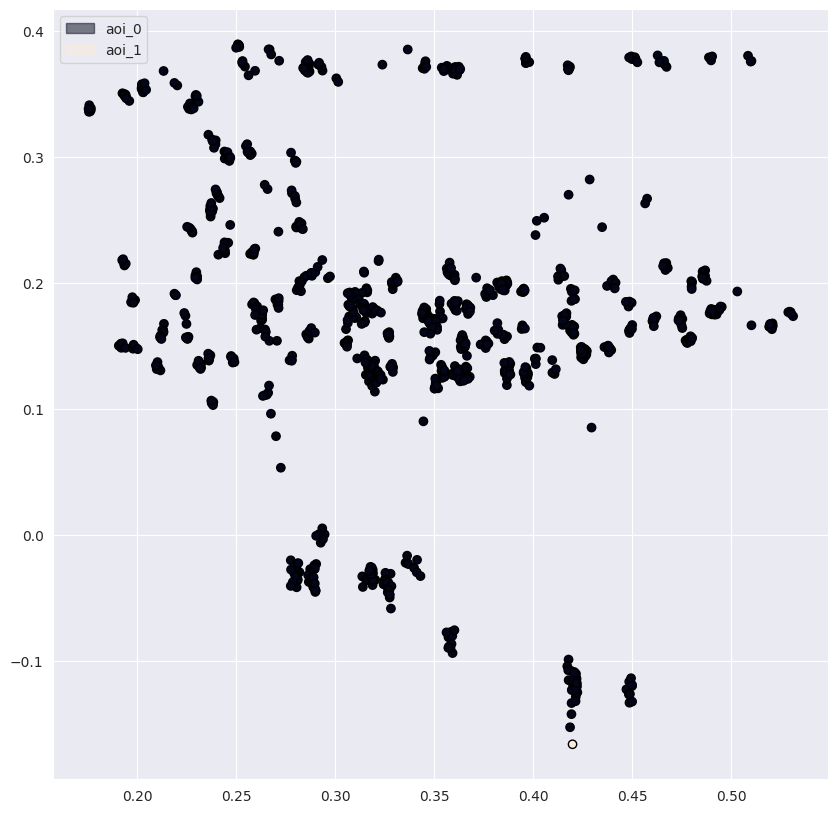

In [8]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 5)], x, y, aoi='AOI', only_points=True, show_legend=True)

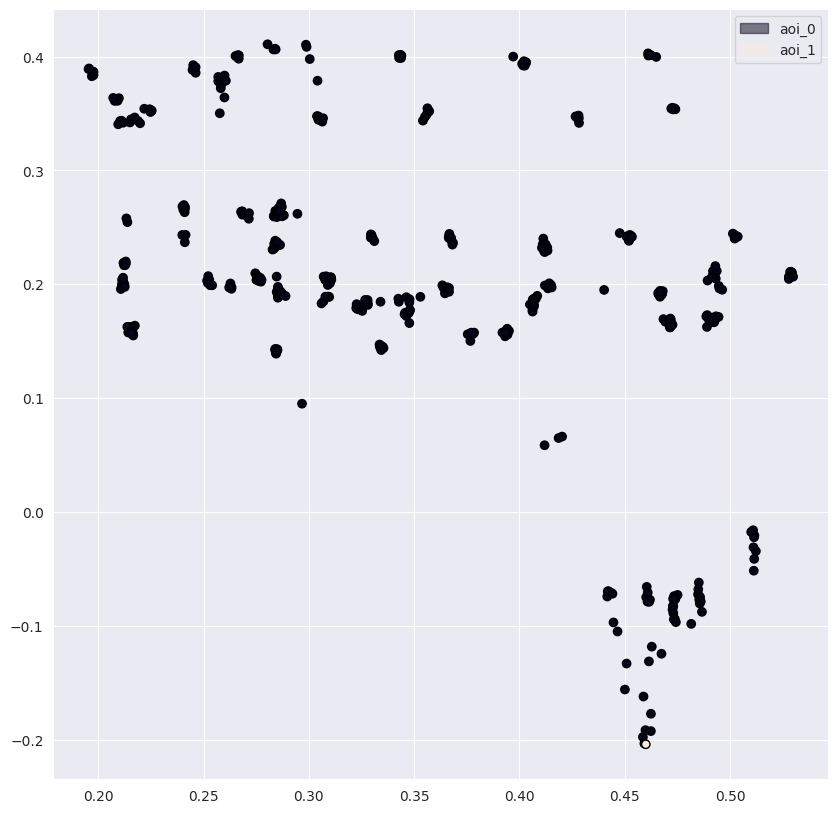

In [9]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 6)], x, y, aoi='AOI', only_points=True, show_legend=True)

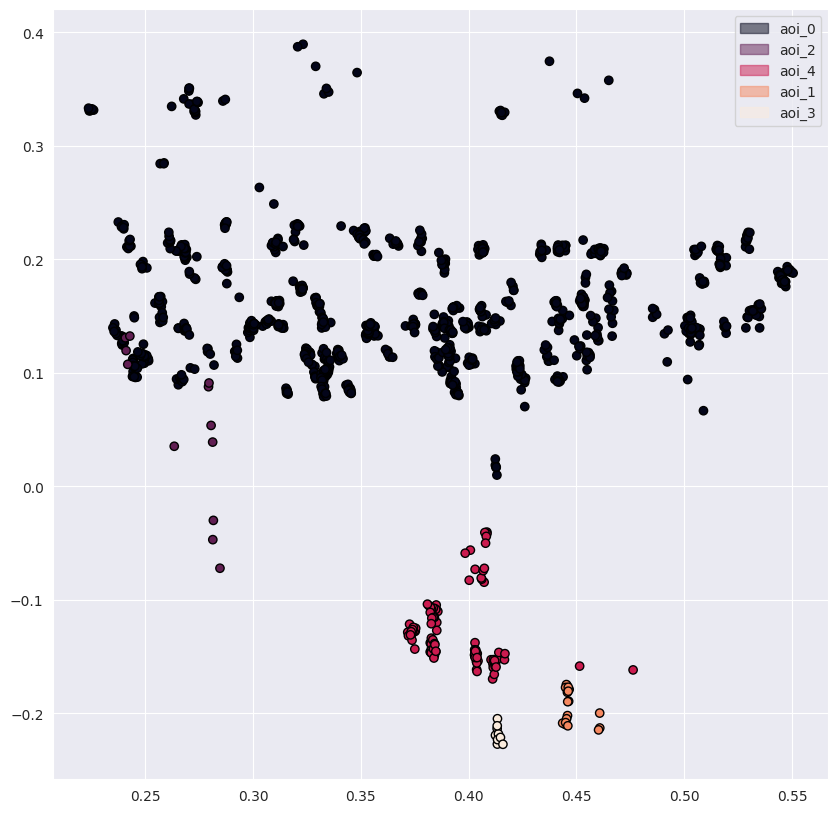

In [10]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 7)], x, y, aoi='AOI', only_points=True, show_legend=True)

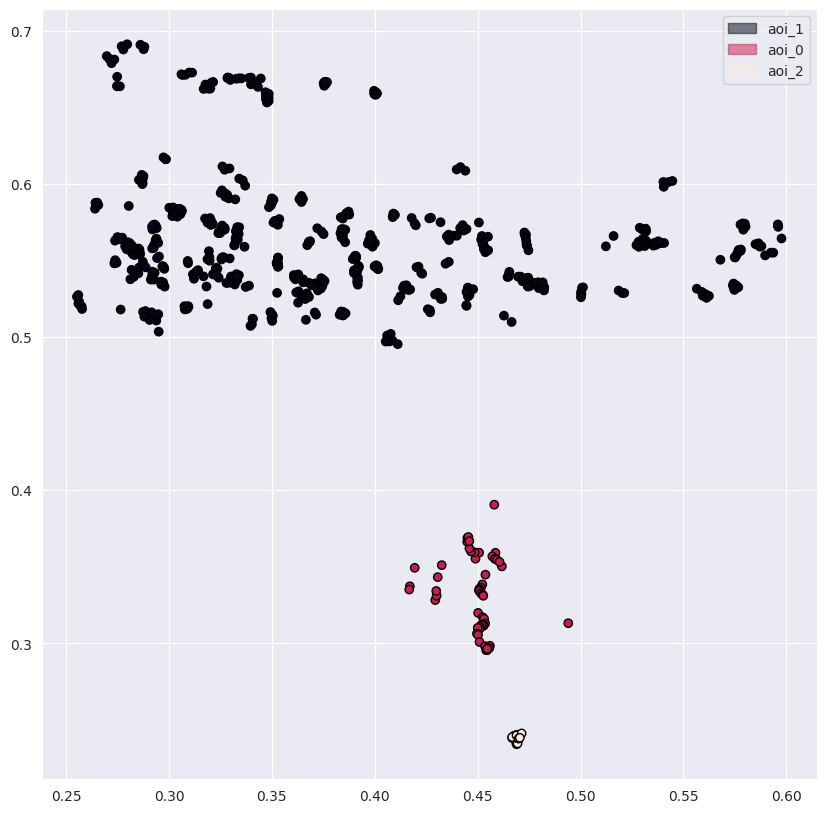

In [11]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 8)], x, y, aoi='AOI', only_points=True, show_legend=True)

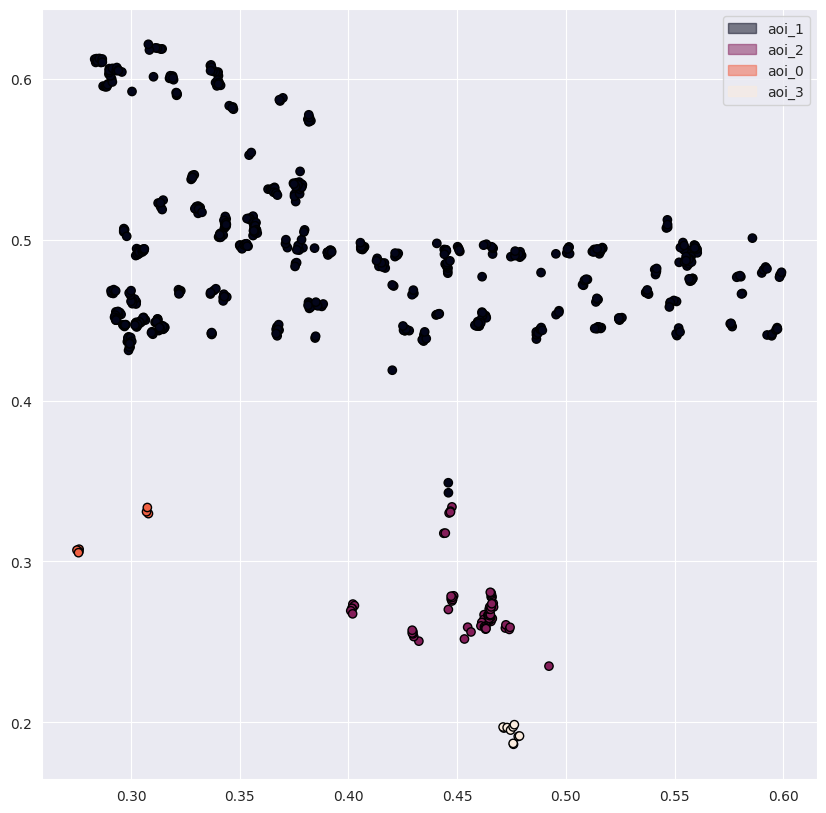

In [12]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 9)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [13]:
prep_data.shape

(51091, 6)

In [14]:
df = pd.concat([prep_data[prep_data['best_method'] == methods[0].__class__.__name__].count(), prep_data[prep_data['best_method'] == methods[1].__class__.__name__].count()], axis=1).transpose()
df['Methods'] = [el.__class__.__name__ for el in methods]
df

,Participant,tekst,norm_pos_x,norm_pos_y,AOI,best_method,Methods
0,35941,35941,35941,35941,35941,35941,ThresholdBased
1,15150,15150,15150,15150,15150,15150,GradientBased


<Axes: xlabel='Methods', ylabel='Participant'>

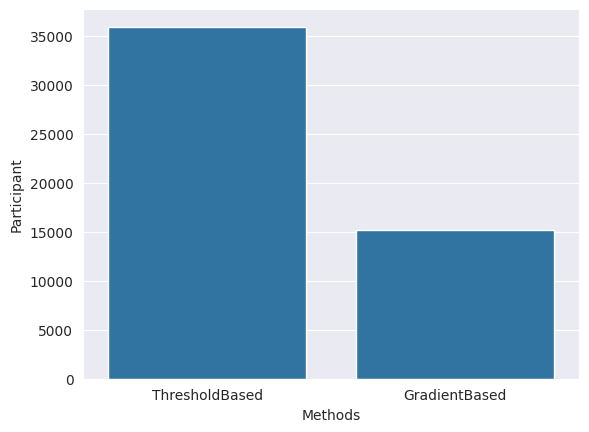

In [15]:
sns.barplot(x=df['Methods'], y=df['Participant'])

In [16]:
ivt = IVT(x=x, y=y, t=t, pk=['Participant', 'tekst'], threshold=0.10)

In [17]:
data_ivt = ivt.transform(data)
data_ivt

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,diameters,centers,duration
0,1,1,0.239144,0.516382,317242.721633,317242.721633,0.000195,0.000195,0.000000,"[0.2391439904733046, 0.5163815125579276]",0.000000
1,1,1,0.244951,0.507583,317242.773274,317242.773274,0.000287,0.000287,0.000000,"[0.2449506645540911, 0.5075828868062189]",0.000000
2,1,1,0.245831,0.504731,317242.785440,317242.798966,0.000179,0.000365,0.000425,"[0.24579086851907433, 0.5047533779782682]",0.013526
3,1,1,0.246993,0.436182,317243.011151,317243.011151,0.000420,0.000420,0.000000,"[0.2469934166829653, 0.4361818760580007]",0.000000
4,1,1,0.247093,0.436844,317243.030597,317243.030597,0.000224,0.000224,0.000000,"[0.2470928360084788, 0.4368439172803136]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...
51086,2,37,0.375928,0.620875,1834.304800,1834.304800,0.000363,0.000363,0.000000,"[0.3759280074761033, 0.6208751460052326]",0.000000
51087,2,37,0.376400,0.620686,1834.324613,1834.324613,0.000187,0.000187,0.000000,"[0.3763997860797801, 0.6206857117840627]",0.000000
51088,2,37,0.376263,0.617110,1834.337344,1834.337344,0.000234,0.000234,0.000000,"[0.3762632420809933, 0.6171101595367645]",0.000000
51089,2,37,0.376046,0.616067,1834.349326,1834.349326,0.000532,0.000532,0.000000,"[0.3760457739903025, 0.6160666060671929]",0.000000


In [18]:
window = 3
threshold = 0.0000001

In [19]:
data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_fix_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_2.xlsx'))], axis=0)
data = remove_points(data, -1, 1, -1, 1)

In [20]:
extr = AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], aoi_name='AOI', show_best=True)
extr.fit(data)
data_aoi = extr.transform(data)

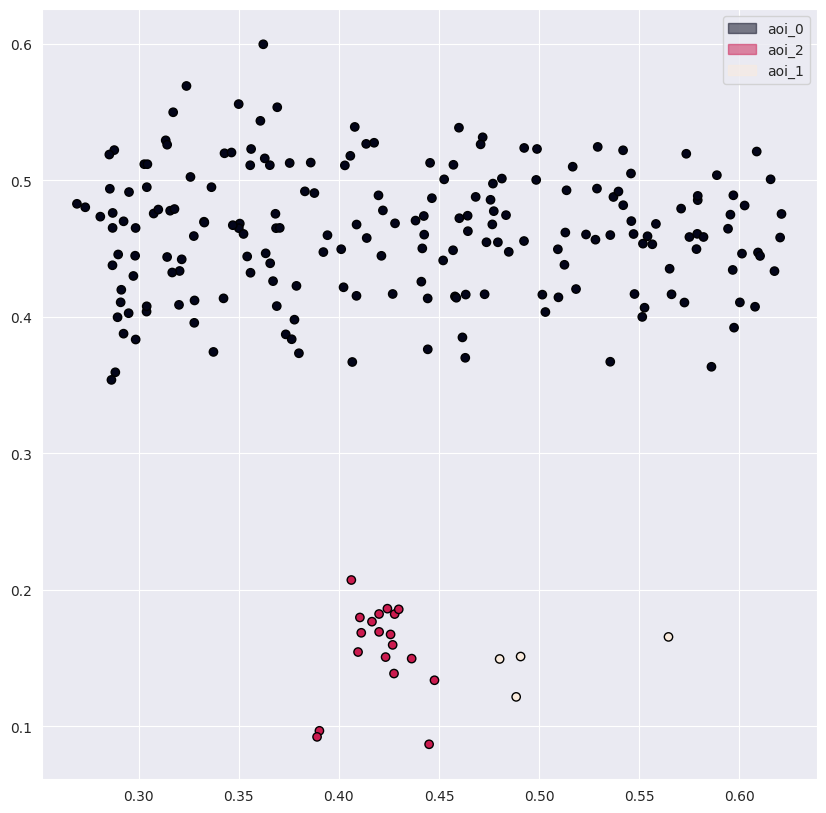

In [21]:
scanpath_visualization(data_aoi[(data_aoi['Participant'] == 1) & (data_aoi['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [22]:
df = pd.concat([data_aoi[data_aoi['best_method'] == methods[0].__class__.__name__].count(), data_aoi[data_aoi['best_method'] == methods[1].__class__.__name__].count()], axis=1).transpose()
df['Methods'] = [el.__class__.__name__ for el in methods]
df

,Participant,tekst,norm_pos_x,norm_pos_y,AOI,best_method,Methods
0,2543,2543,2543,2543,2543,2543,ThresholdBased
1,5437,5437,5437,5437,5437,5437,GradientBased


<Axes: xlabel='Methods', ylabel='Participant'>

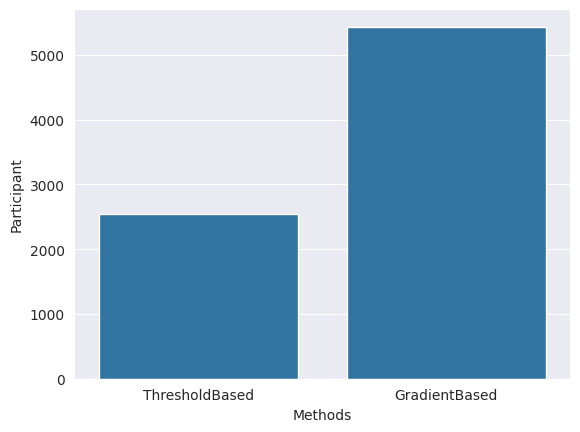

In [23]:
sns.barplot(x=df['Methods'], y=df['Participant'])

In [24]:
gradient_b = GradientBased(x=x, y=y, window_size=window, threshold=threshold, aoi_name="AOI", pk=['Participant', 'tekst'])

In [25]:
res_grad = gradient_b.transform(data)

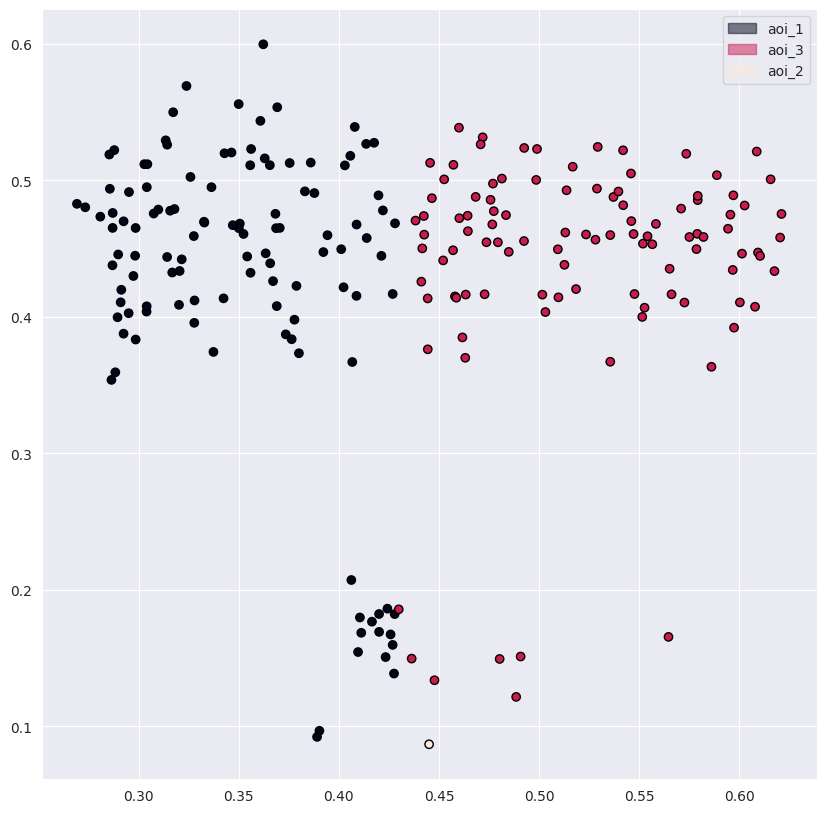

In [26]:
scanpath_visualization(res_grad[(res_grad['Participant'] == 1) & (res_grad['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [27]:
threshold_b = ThresholdBased(x=x, y=y, window_size=window, threshold=threshold, aoi_name="AOI", pk=['Participant', 'tekst'])

In [28]:
data_thr = threshold_b.transform(data)
data_thr.head(15)

,Participant,tekst,id,duration,confidence,start_frame_index,start_timestamp,end_frame_index,dispersion,norm_pos_x,norm_pos_y,AOI
0,1,1,998,208.1115,0.999697,1806,317242.694809,1807,1.330883,0.242478,0.508895,aoi_0
1,1,1,999,209.2905,1.000000,1807,317242.913454,1808,1.650276,0.246931,0.433742,aoi_0
2,1,1,1000,235.8615,1.000000,1809,317243.128721,1810,1.249983,0.240074,0.408932,aoi_0
3,1,1,1001,231.0985,0.999868,1810,317243.376751,1812,1.097607,0.203017,0.505386,aoi_0
4,1,1,1002,225.3285,0.999293,1812,317243.633292,1813,1.206289,0.272986,0.503568,aoi_0
5,1,1,1003,195.6350,0.996236,1814,317243.892925,1815,0.865583,0.337278,0.503325,aoi_0
6,1,1,1004,133.8075,0.995381,1815,317244.127373,1816,0.902115,0.301874,0.084666,aoi_1
7,1,1,1005,159.5990,0.998758,1816,317244.273837,1817,0.945018,0.307556,0.049586,aoi_1
8,1,1,1006,285.3845,0.996358,1817,317244.462169,1819,1.069484,0.368521,0.169918,aoi_1
9,1,1,1007,101.4980,0.989692,1819,317244.785353,1820,0.772557,0.237429,0.318506,aoi_0


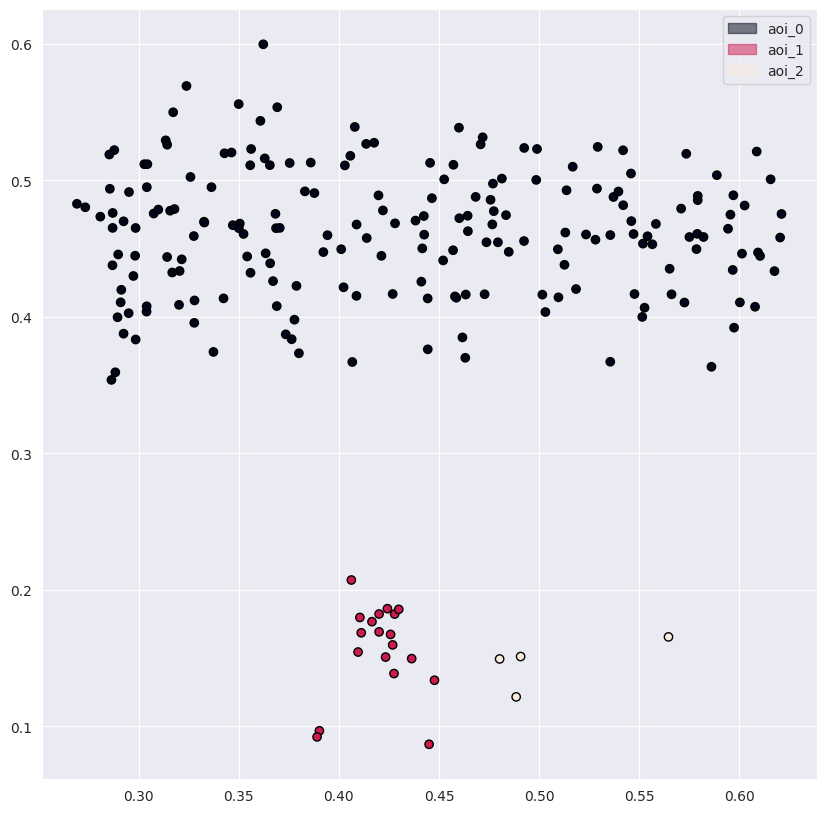

In [29]:
scanpath_visualization(data_thr[(data_thr['Participant'] == 1) & (data_thr['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)